<img src="imgs/IISc_Master_Seal_Black_Transparent.png" height="120px" width="120px" align="right" />

<img src="imgs/logoGESS.jpg" height="120px" width="120px" align="right" />

<font face="Calibri">
<br>
<font size="7"> <b> PySHBundle Tutorials </b> </font>
<br> <br>
<font size="5"> <b> Tutorial 2: Load Spherical Harmonics data from JPL, CSR and ITSG<font color='rgba(200,0,0,0.2)'>  </font> </b> </font>
<br> <br>
    
<font size="3"> <b> by: Abhishek Mhamane, IIT Kanpur</b> 
<font size="2">  <br>
<font> <b>Date: </b> August 23, 2023 </font>
</font>


In [1]:
import os
import pprint
import numpy as np
from tqdm import tqdm, trange
from datetime import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
from pyshbundle.io import parse_jpl_file, parse_csr_file, parse_itsg_file
from pyshbundle.io import extract_SH_data
from pyshbundle.io import extract_SH_data, extract_deg1_coeff_tn13, extract_deg2_3_coeff_tn14
from pyshbundle.reshape_SH_coefficients import klm2sc
from pyshbundle.viz_utils import plot_calendar_months

Initializing PySHbundle v0.3.0


## 1.1 GRACE Level-2 Data

This dataset contains estimates of the total month-by-month geopotential of the Earth, derived from the Gravity Recovery and Climate Experiment Follow-On (GRACE-FO) mission measurements

For more details refer to [GRACE Products by GFZ Postdam](https://www.gfz-potsdam.de/en/section/global-geomonitoring-and-gravity-field/projects/grace/grace-products)

## Data Source - CSR

Data loading steps are more or less similar for different data sources, still procedure for different sources have been explained in this tutorial.

In [14]:
# path_sh = "../sample_input_data/JPL_input/"
# source='csr'
# path_sh = "../sample_input_data/CSR_input/"
# source='itsg'
# path_sh = "../sample_input_data/ITSG_input/"

source='itsg'
path_sh='../data/ITSG_input/'
file_path='../data/ITSG_input/ITSG-Grace2018_n96_2002-04.gfc'

## Read the files (single and multiple files)

For the GRACE data files, the function `read_csr` parses the header info as well as the numerical data into a `dict` and `matrix` format respectively. <br>

for additional information see the documentation or use `help(read_csr)`

### Single file

In [6]:
itsg_header, itsg_data = parse_itsg_file(file_path)

In [7]:
# pretty printing the header info
pp = pprint.PrettyPrinter(indent=2, width=2, compact=True);
pp.pprint(itsg_header[0:1])

[ 'Unconstrained '
  'GRACE-only '
  'monthly '
  'gravity '
  'field '
  'solution '
  'computed '
  'at '
  'TU '
  'Graz\n']


The `klm_mat` contains the numerical data; of size (n, 6) <br> <br>

The columns of the matrix (np.ndarray) are [degree, order, c_lm, s_lm, dev_c_lm, dev_s_lm] <br>

NOTE: CSR provides data in the `KLM` format whereas JPL and ITSG provides in `CLM` format

In [8]:
# the numerical data
itsg_data['coefficients'][(0,0)]

{'Clm': np.float64(1.0),
 'Slm': np.float64(0.0),
 'Clm_sdev': np.float64(0.0),
 'Slm_sdev': np.float64(0.0)}

The shape of the `klm_mat` matrix indicates there are 4753 data rows in the 

The dates have been reported seperately so as to maintain consistency with data provided by other data processing centers.

### Format conversion

In [9]:
max_degree, max_order=max(itsg_data['coefficients'].keys())
number_of_months=len(itsg_data['coefficients'].keys())
print('The maximum degree & order in data is:' , max_degree, '&', max_order)

The maximum degree & order in data is: 96 & 96


In [10]:
# Currently the data is in an data matrix, for efficient computation it needs to converted to /S|C\ or |C\S| format

sc_mat=np.zeros([max_degree+1, 2*(max_degree+1)], dtype=np.double)
sc_mat_std_dev=np.zeros([max_degree+1, 2*(max_degree+1)], dtype=np.double)

temp=itsg_data['coefficients']
for l in range(0,max_degree+1):
    for m in range(0,l+1):
        '''uncomment these two lines to see how the elements are being accessed from the dictionary'''
        # print(l,m)
        # print(temp[(l,m)]['Clm'])
        sc_mat[l, max_degree+m+1]=temp[(l,m)]['Clm']
        sc_mat[l, max_degree-m]=temp[(l,m)]['Slm']
        sc_mat_std_dev[l, max_degree+m+1]=temp[(l,m)]['Clm_sdev']
        sc_mat_std_dev[l, max_degree-m]=temp[(l,m)]['Slm_sdev']
del temp
sc_mat=np.delete(sc_mat, max_degree, axis=1);
sc_mat_std_dev=np.delete(sc_mat_std_dev, max_degree, axis=1);

Visualize the /C|S\ foramt

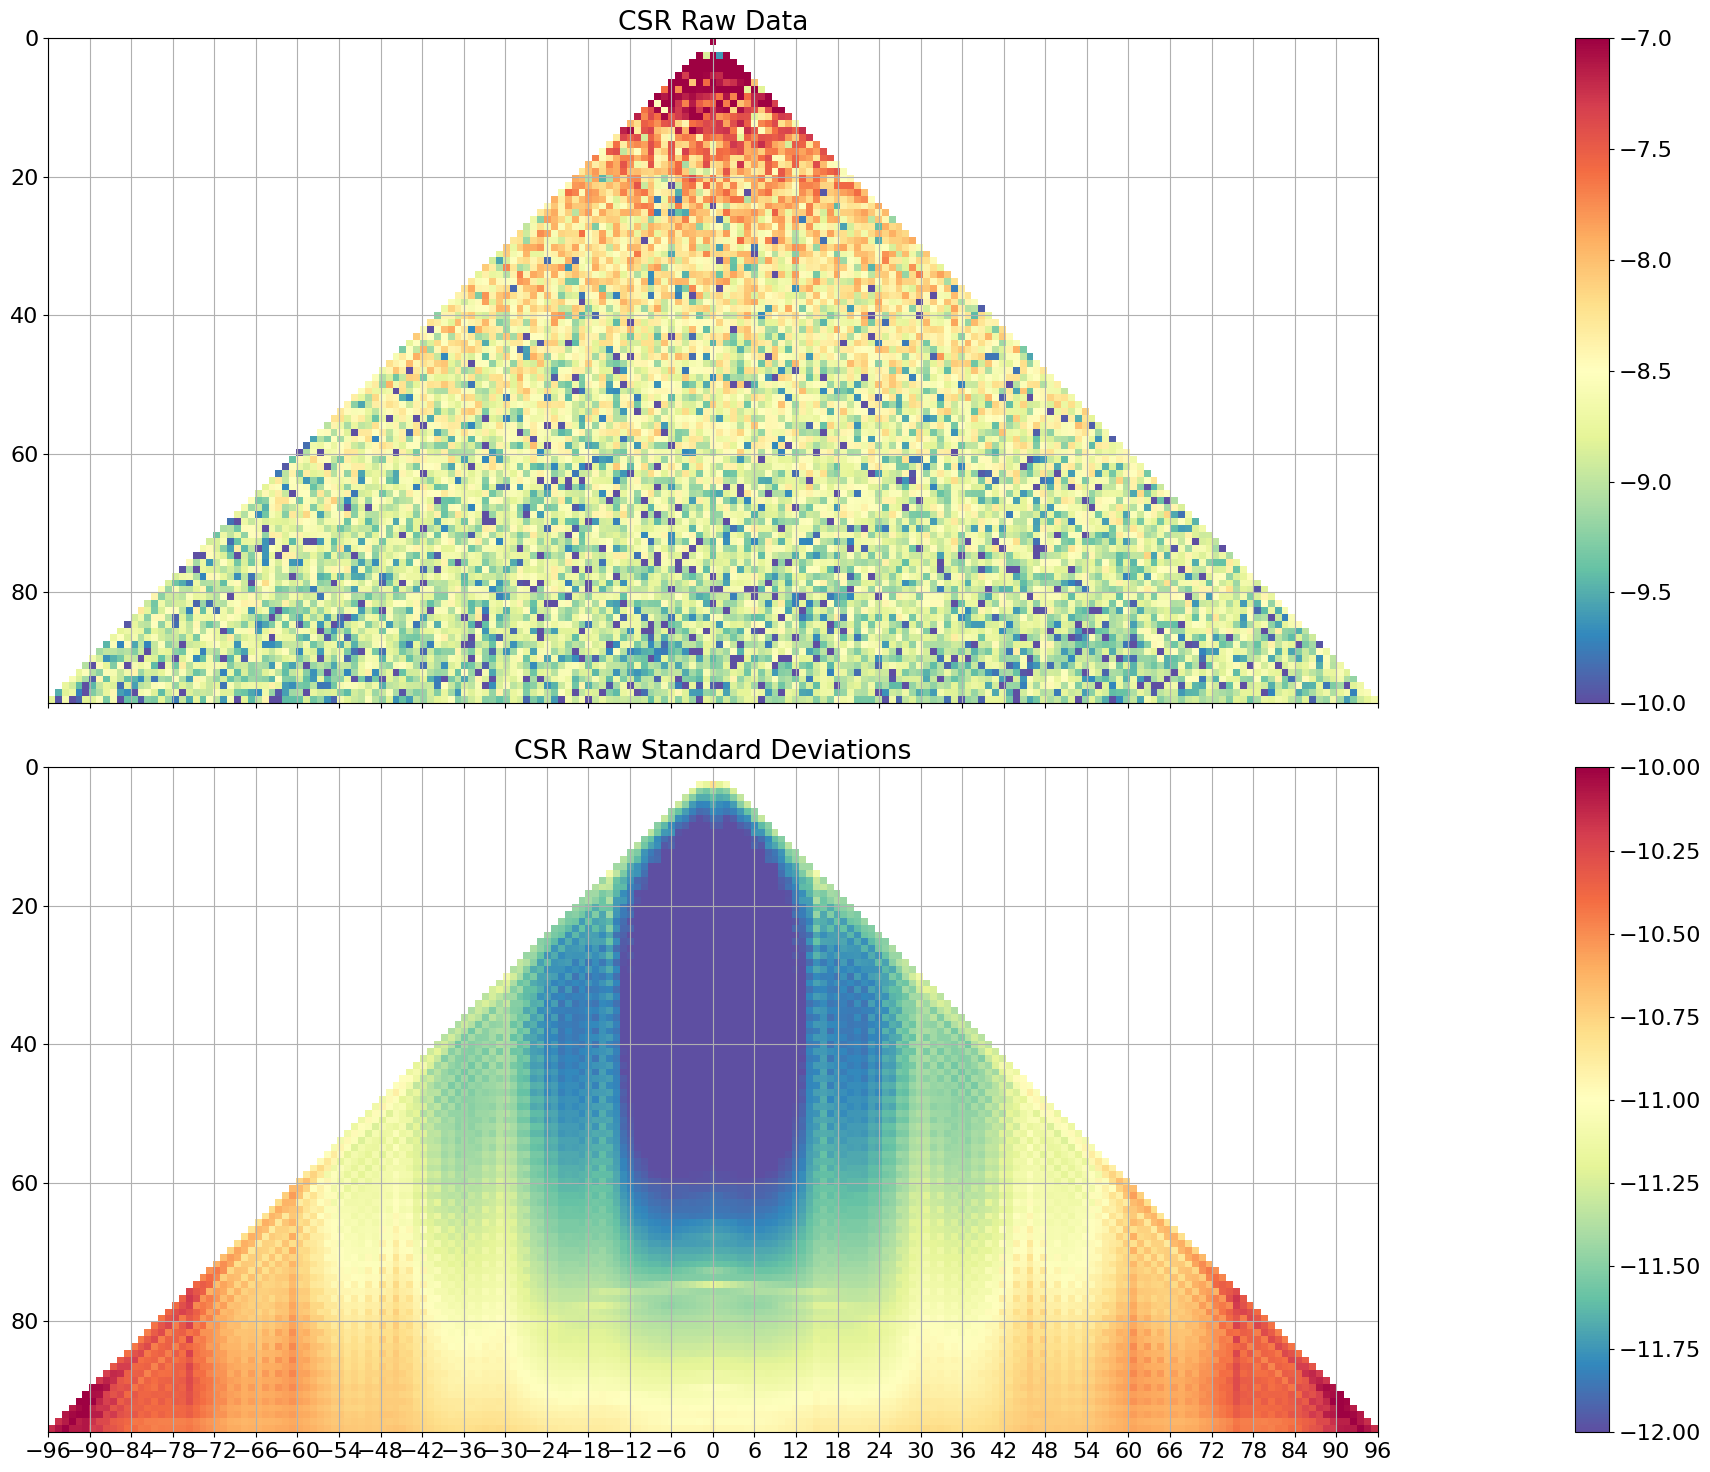

In [11]:
plt.rcParams.update({'font.size': 16})

x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

fig, ax = plt.subplots(2, 1,figsize=(40, 15), sharex=True, sharey=True)
raw_dat = ax[0].imshow(np.ma.log10(np.absolute(sc_mat)), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-10, vmax=-7, )
ax[0].title.set_text("CSR Raw Data")

fig.colorbar(raw_dat, )

raw_dev = ax[1].imshow(np.ma.log10(np.absolute(sc_mat_std_dev)), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
ax[1].title.set_text("CSR Raw Standard Deviations")
plt.sca(ax[1])
plt.xticks(x_vec, color='black')
fig.colorbar(raw_dev,)

ax[0].grid()
ax[1].grid()

# plt.colorbar()

fig.tight_layout()
plt.show()


### Reading Multiple Files

Lets create a list of the file paths in of our data.

In [15]:
files = os.listdir(path_sh)
if str.upper(source) == 'ITSG':
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gfc'];
else:
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gz'];

In [16]:
extracted_data={} 
for file_path in file_paths:
    # file_data = read_sh(file_path, source=source)
    file_data = extract_SH_data(file_path, source=source)
    if file_data['time_coverage_start']:
        # Convert time_coverage_start to a datetime object and then format it as yyyy-mm
        if source == 'itsg':
            start_date = datetime.strptime(file_data['time_coverage_start'][-7:], '%Y-%m').strftime('%Y-%m')
        else:
            start_date = datetime.strptime(file_data['time_coverage_start'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m')
        # Use the formatted date as the key
        extracted_data[start_date] = file_data['coefficients']


# Time Sort the dictionary by keys (dates)
sorted_data = OrderedDict(sorted(extracted_data.items()));

## Read Replacement files

Since the degree 2 & 3 (order 0) coefficients from GRACE are errorneous, these need to be replaced with the corresponding data from other sources. 

The recommended method is using Satellite laser ranging data. As mentioned above, we do provide the `TN14` data (JPL, CSR, & ITSG) with the package. Since this data is continuously updated users may download there own solutions for the same and use for replacement of `C20` and `C30` coefficients.

In [19]:
# here example is shown for the csr replacement files

path_csr_tn13 = '../pyshbundle/data/CSR_TN_files/TN-13_GEOC_CSR_RL0602.txt'
path_csr_tn14 = '../pyshbundle/data/CSR_TN_files/TN-14_C30_C20_GSFC_SLR.txt'


In [20]:
data_tn13_csr = extract_deg1_coeff_tn13(path_csr_tn13)

In [21]:
print('Keys of the TN13 replacement dictionary', data_tn13_csr.keys(),)        # dicitonary for each year-month
print('Keys of dictionary for year-month 2002-4', data_tn13_csr[('2002-04', 1, 0)].keys())  # dictionary for c20, c30 coefficients for each year-month
print('For 2002-04 :',  '\n'
       'C10 is:', data_tn13_csr[('2002-04', 1, 0)]['Clm'], '\n'
       'S10 is:', data_tn13_csr[('2002-04', 1, 0)]['Slm'], '\n'
       'C11 is:', data_tn13_csr[('2002-04', 1, 1)]['Clm'], '\n'
       'C11 is:', data_tn13_csr[('2002-04', 1, 1)]['Slm'])

Keys of the TN13 replacement dictionary dict_keys([('2002-04', 1, 0), ('2002-04', 1, 1), ('2002-05', 1, 0), ('2002-05', 1, 1), ('2002-08', 1, 0), ('2002-08', 1, 1), ('2002-09', 1, 0), ('2002-09', 1, 1), ('2002-10', 1, 0), ('2002-10', 1, 1), ('2002-11', 1, 0), ('2002-11', 1, 1), ('2002-12', 1, 0), ('2002-12', 1, 1), ('2003-01', 1, 0), ('2003-01', 1, 1), ('2003-02', 1, 0), ('2003-02', 1, 1), ('2003-03', 1, 0), ('2003-03', 1, 1), ('2003-04', 1, 0), ('2003-04', 1, 1), ('2003-05', 1, 0), ('2003-05', 1, 1), ('2003-07', 1, 0), ('2003-07', 1, 1), ('2003-08', 1, 0), ('2003-08', 1, 1), ('2003-09', 1, 0), ('2003-09', 1, 1), ('2003-10', 1, 0), ('2003-10', 1, 1), ('2003-11', 1, 0), ('2003-11', 1, 1), ('2003-12', 1, 0), ('2003-12', 1, 1), ('2004-01', 1, 0), ('2004-01', 1, 1), ('2004-02', 1, 0), ('2004-02', 1, 1), ('2004-03', 1, 0), ('2004-03', 1, 1), ('2004-04', 1, 0), ('2004-04', 1, 1), ('2004-05', 1, 0), ('2004-05', 1, 1), ('2004-06', 1, 0), ('2004-06', 1, 1), ('2004-07', 1, 0), ('2004-07', 1, 1),

In [22]:
data_tn14_csr = extract_deg2_3_coeff_tn14(path_csr_tn14)

In [23]:
print('Keys of the TN14 replacement dictionary', data_tn14_csr.keys(),)        # dicitonary for each year-month
print('Keys of dictionary for year-month 2002-4', data_tn14_csr['2002-04'].keys())  # dictionary for c20, c30 coefficients for each year-month
print('For 2002-04 :',  '\n'
      'C20 is:', data_tn14_csr['2002-04']['c20'], '\n'
      'C30 is:',data_tn14_csr['2002-04']['c30'])

Keys of the TN14 replacement dictionary dict_keys(['2002-04', '2002-05', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '20

## Replace Low Degree Coefficients

###  Let's Observe the Replacement Steps/Procedure

## Visualizing the Coefficients

* First we need to convert the data into the `/S|C\` format

In [24]:
sc_mat=np.zeros([number_of_months, max_degree+1, 2*(max_degree+1)], dtype=np.double)
sc_mat_std_dev=np.zeros([number_of_months, max_degree+1, 2*(max_degree+1)], dtype=np.double)

for index, key in enumerate(sorted_data.keys()):
    temp=sorted_data[key]
    for l in range(0,max_degree+1):
        for m in range(0,l+1):
            '''uncomment these two lines to see how the elements are being accessed from the dictionary'''
            # print(l,m)
            # print(temp[(l,m)]['Clm'])
            sc_mat[index, l, max_degree+m+1]=temp[(l,m)]['Clm']
            sc_mat[index, l, max_degree-m]=temp[(l,m)]['Slm']
            sc_mat_std_dev[index, l, max_degree+m+1]=temp[(l,m)]['Clm_sdev']
            sc_mat_std_dev[index, l, max_degree+m+1]=temp[(l,m)]['Slm_sdev']
    del temp
sc_mat=np.delete(sc_mat, max_degree, axis=2);

In [25]:
def de_sparse(vec):
    de_sparse_vec = []
    for elem in vec:
        if elem:
            de_sparse_vec.append(elem)
    
    return de_sparse_vec

/Users/vivek/miniconda3/envs/pysh/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vivek/miniconda3/envs/pysh/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


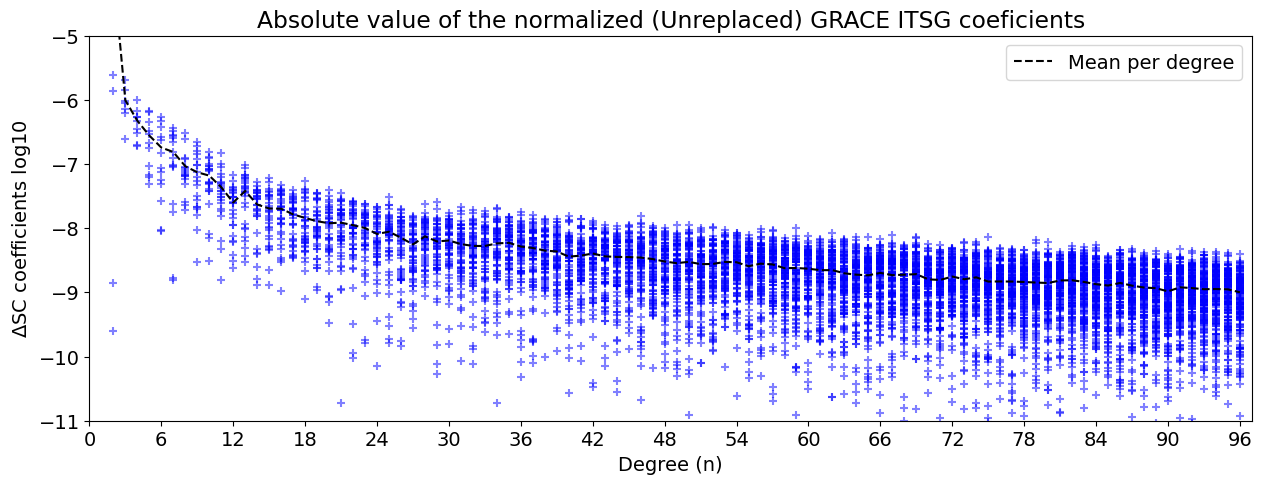

In [26]:
sc_matrix=sc_mat[0,:,:]  # select the first months spherical harmonic coefficients 

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
degree_mean = []
for i in range(97):
    desparsed = np.absolute(de_sparse(sc_matrix[i, :]))
    degree_mean.append(np.mean(desparsed))
    x = i * np.ones((len(desparsed)))

    ax.scatter(x, np.log10(desparsed), color='blue', marker='+', alpha=0.5)

ax.plot(range(97), np.log10(degree_mean), 'k', linestyle='--', label="Mean per degree")

x_vec = np.arange(0, 96+1, 6)

plt.ylim([-11, -5])
plt.xlim([0, 97])
plt.ylabel("$\\Delta$SC coefficients log10", fontsize=14)
plt.xlabel("Degree (n)")
plt.xticks(x_vec)
plt.title("Absolute value of the normalized (Unreplaced) GRACE ITSG coeficients")
plt.legend()
plt.show()

* Thank you for reading this notebook.